# Setup

In [1]:
%pip install plotly
%pip install transformer-lens
%pip install fancy-einsum
%pip install jax
%pip install jaxtyping==0.2.12
%pip install torchtyping

import plotly.io as pio
try:
    import google.colab
    print("Running as a Colab notebook")
    pio.renderers.default = "colab"
    %pip install transformer-lens fancy-einsum
    %pip install -U kaleido # kaleido only works if you restart the runtime. Required to write figures to disk (final cell)
except:
    print("Running as a Jupyter notebook")
    pio.renderers.default = "vscode"
    from IPython import get_ipython
    ipython = get_ipython()


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.2 MB/s eta 0:00:0000:01
  Created wheel for jax: filename=jax-0.4.14-py3-none-any.whl size=1535361 

In [2]:
import torch
from fancy_einsum import einsum
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils, ActivationCache
from torchtyping import TensorType as TT
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import einops
from typing import List, Union, Optional
from functools import partial
import pandas as pd
from pathlib import Path
import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm
from datasets import load_dataset
import os
import json

os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://stackoverflow.com/q/62691279
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
!pip install circuitsvis
import circuitsvis as cv


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
pio.renderers.default='vscode'

def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [5]:
model = HookedTransformer.from_pretrained(
    "gpt2-large",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    device=device,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


## Find Activating Examples

In [71]:
from datasets import load_dataset
# dataset = load_dataset("NeelNanda/pile-10k", split="train")
import pickle
with open("./data/text_list_dict_test.pkl", "rb") as f:
    dataset = pickle.load(f)

In [72]:
# dataset_text_list = dataset.to_dict()['text']
dataset_text_list = [x['text'] for x in dataset]
# print(model.to_tokens(dataset.to_dict()['text'][0:5]).shape)
print(model.to_tokens(dataset_text_list[0:5]).shape)

torch.Size([5, 584])


In [73]:
stupid_texts = [x for x in dataset_text_list if " stupid" in x]
# Filter for the 1000 characters before the word "stupid"
stupid_texts = [x[x.find(" stupid")-200:x.find(" stupid")] for x in stupid_texts]

In [122]:
string = " fuck"
string_texts = [x for x in dataset_text_list if string in x]
print(string_texts[0])
string_texts = [x[max(0, x.find(string)-100):x.find(string)+len(string)] for x in string_texts]

this guy is fit as fuck - love a guy pissing on himself, especially when fully clothed! hot stuff!

this guy is fit as fuck - love a guy pissing on himself, especially when fully clothed! hot stuff!


In [ ]:
import evaluate
toxicity = evaluate.load("toxicity")

In [123]:
# batch_size = 10
# for i in range(0, len(stupid_texts), batch_size):
    # batch = stupid_texts[i:i+batch_size]
    # results = toxicity.compute(predictions=stupid_texts[i:i+batch_size])
    # print(results)
    # break
# results = toxicity.compute(predictions=stupid_texts)
results = toxicity.compute(predictions=string_texts)

In [107]:
string_texts[0]

''

In [124]:
for string_text, score in zip(string_texts, results['toxicity']):
    print(score, string_text)

0.0002880319079849869 this guy is fit as fuck
0.04170963913202286 n skin Twi'lek and couple people in light armor shooting at the thugs from ruined vehicle.

"Get the fuck
0.026764407753944397  writing this I actually start to get a little bit of RSI, haha!

Conclusion

Start now so you won’t fuck
0.008255407214164734  in her dressing room, mean-mugging a tall cool glass of refreshing water and muttering You’ll never fuck
0.010713256895542145  "[ALL LAUGHING]" " Danny in yet?" " In the office." " Here he goes." "Here he goes." "MAN 2:" "He's fuck
0.9159104824066162  what his name was Clarence or
something like that
oh he kissed my girl but I'm still up
here saying fuck
0.0028550049755722284 . Her face? Her neck? All I knew was that her fingers released. I spun, gasping, ready to run.

"She fuck
0.001199821475893259 the bait.

Rina pulls up her dress and shows Kyle her tight, slim body. The commanding stud fiercely fuck
0.05823623016476631 orld, especially when there are stories in the 

(array([48.,  4.,  1.,  2.,  2.,  1.,  0.,  3.,  0., 12.]),
 array([1.32362678e-04, 1.00088764e-01, 2.00045165e-01, 3.00001566e-01,
        3.99957967e-01, 4.99914368e-01, 5.99870769e-01, 6.99827171e-01,
        7.99783572e-01, 8.99739973e-01, 9.99696374e-01]),
 <BarContainer object of 10 artists>)

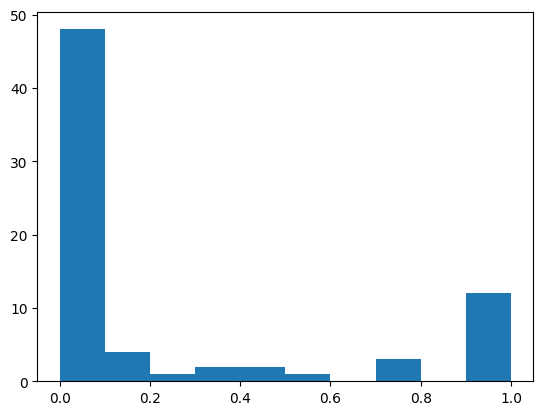

In [93]:
# plot histogram of results
from matplotlib import pyplot as plt
plt.hist(results['toxicity'])

In [91]:
sorted_results = sorted(results['toxicity'], reverse=True)
print(sorted_results[0:10])

[0.9996963739395142, 0.99946528673172, 0.999373733997345, 0.9974429607391357, 0.9834463000297546, 0.9761113524436951, 0.9720401167869568, 0.9370946288108826, 0.9204860925674438, 0.9190689325332642]


In [12]:
neurons_json = json.load(open("neuron_finder_results.json"))
neurons = []
for layer, results in neurons_json.items():
    indices = results.keys()
    for index in indices:
        neurons.append((int(layer), int(index)))

print(neurons)

[(31, 3621), (31, 364), (31, 2918), (31, 4378), (31, 988), (31, 2658), (31, 2692), (31, 4941), (31, 2415), (31, 1407), (32, 4964), (32, 2412), (32, 4282), (32, 3151), (32, 1155), (32, 1386), (32, 3582), (32, 4882), (32, 3477), (32, 406), (33, 1202), (33, 524), (33, 1582), (33, 4446), (33, 204), (33, 4900), (33, 2322), (33, 3278), (33, 1299), (33, 52), (34, 4012), (34, 4262), (34, 320), (34, 5095), (34, 2599), (34, 2442), (34, 4494), (34, 4199), (34, 727), (34, 4410), (35, 4518), (35, 48), (35, 5014), (35, 3724), (35, 3360), (35, 885), (35, 4924), (35, 274), (35, 2369), (35, 4638)]


In [13]:
def get_neurons_acts(model, texts, neurons):
    tokens = model.to_tokens(texts)
    
def cache_to_tuples(cache):
    new_cache = {}
    for key in cache.keys():
        x = torch.max(cache[key], dim=1)
        y = list(x)
        y = [y[0].tolist(), y[1].tolist()]
        y = list(zip(*y))
        new_cache[key] = y # y is a list of tuples, i.e. [(max_value, max_index), ...]
    return new_cache

In [23]:
batch_size = 4
batched_texts = [dataset_text_list[i: i+batch_size] for i in range(0, len(dataset_text_list), batch_size)]
print(len(batched_texts))

neuron_max_acts = {neuron: [] for neuron in neurons}

for texts in tqdm(batched_texts):
    model.reset_hooks()

    cache = {}

    def return_caching_hook(neuron):
        layer, neuron_index = neuron
        def caching_hook(act, hook):
            cache[(layer, neuron_index)] = act[:, :, neuron_index] # act shape is (batch_size, seq_len, neuron_index)
        return caching_hook
    
    hooks = list(((f"blocks.{layer}.mlp.hook_post", return_caching_hook((layer, index))) for layer, index in neurons))
    print(hooks)

    model.run_with_hooks(
        model.to_tokens(texts).to(device),
        fwd_hooks=hooks,
    )
    cache = cache_to_tuples(cache)

    for key in cache.keys():
        neuron_max_acts[key].extend(cache[key])



In [ ]:
save_file = False

In [25]:
neuron_max_acts_json = {str(key): value for key, value in neuron_max_acts.items()}

if save_file:
    with open("neuron_max_acts_test.json", "w") as f:
        json.dump(neuron_max_acts_json, f)
        save_file = False

In [27]:
with open("neuron_max_acts_test.json", "r") as f:
    neuron_max_acts_load = json.load(f)

print(neuron_max_acts_load.keys())
# This is a dictionary with string keys '(layer, neuron)', and each value is a list of [(activation, index)] where each tuple is an example.

dict_keys(['(31, 3621)', '(31, 364)', '(31, 2918)', '(31, 4378)', '(31, 988)', '(31, 2658)', '(31, 2692)', '(31, 4941)', '(31, 2415)', '(31, 1407)', '(32, 4964)', '(32, 2412)', '(32, 4282)', '(32, 3151)', '(32, 1155)', '(32, 1386)', '(32, 3582)', '(32, 4882)', '(32, 3477)', '(32, 406)', '(33, 1202)', '(33, 524)', '(33, 1582)', '(33, 4446)', '(33, 204)', '(33, 4900)', '(33, 2322)', '(33, 3278)', '(33, 1299)', '(33, 52)', '(34, 4012)', '(34, 4262)', '(34, 320)', '(34, 5095)', '(34, 2599)', '(34, 2442)', '(34, 4494)', '(34, 4199)', '(34, 727)', '(34, 4410)', '(35, 4518)', '(35, 48)', '(35, 5014)', '(35, 3724)', '(35, 3360)', '(35, 885)', '(35, 4924)', '(35, 274)', '(35, 2369)', '(35, 4638)'])


In [28]:
for key in neuron_max_acts_load.keys():
    x = neuron_max_acts_load[key]
    # Get the maximum of the first integer of each tuple, and get its index
    max_value, max_index = max(x, key=lambda x: x[0])
    print(key, max_value)

(31, 3621) 10.251951217651367
(31, 364) 9.740968704223633
(31, 2918) 11.068354606628418
(31, 4378) 8.716076850891113
(31, 988) 11.621490478515625
(31, 2658) 12.82618236541748
(31, 2692) 8.118934631347656
(31, 4941) 9.717790603637695
(31, 2415) 12.619271278381348
(31, 1407) 11.456319808959961
(32, 4964) 9.563413619995117
(32, 2412) 11.053483009338379
(32, 4282) 10.273469924926758
(32, 3151) 11.574091911315918
(32, 1155) 17.580238342285156
(32, 1386) 7.693735122680664
(32, 3582) 7.891524314880371
(32, 4882) 8.122246742248535
(32, 3477) 13.211039543151855
(32, 406) 10.476919174194336
(33, 1202) 11.42226505279541
(33, 524) 11.018861770629883
(33, 1582) 6.501070976257324
(33, 4446) 6.173979759216309
(33, 204) 7.025345802307129
(33, 4900) 5.91392183303833
(33, 2322) 10.92375659942627
(33, 3278) 8.334972381591797
(33, 1299) 7.901394367218018
(33, 52) 7.129082679748535
(34, 4012) 13.173219680786133
(34, 4262) 11.977959632873535
(34, 320) 10.76593017578125
(34, 5095) 11.963262557983398
(34, 259

In [29]:
# Scatter plot a neuron
neuron_str = "(35, 3724)"
x = neuron_max_acts_load[neuron_str]
# Scatter plot the activations
scatter(
    x=[i for i in range(len(x))],
    y=[i[0] for i in x],
    xaxis="Text index",
    yaxis="Activation",
    caxis="",
    title=f"Activations for neuron {neuron_str}",
)